1 ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


2 データ読み込みと確認

In [2]:
# 前処理済みデータの読み込み
df = pd.read_csv('../data/processed/processed_data.csv')

# 基本情報を確認
display(df.head())
print(df.info())
print(df['target'].value_counts(normalize=True))

,horse_number,actual_weight,declared_horse_weight,draw,length_behind_winner,finish_time,win_odds,target,jockey_A Badel,jockey_A Sanna,...,trainer_T P Yung,trainer_T Tanaka,trainer_W A Ward,trainer_W H Tse,trainer_W Y So,trainer_Y C Fung,trainer_Y Ikee,trainer_Y S Tsui,trainer_Y Yahagi,trainer_de Royer Dupre
0,1.0,133,1032,1,5.843927,NaN,3.8,1,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2.0,133,1075,13,2.000000,NaN,8.0,1,False,False,...,False,False,False,False,False,False,False,False,False,False
2,10.0,121,1065,3,2.000000,NaN,5.7,1,False,False,...,False,False,False,False,False,False,False,True,False,False
3,3.0,132,1222,2,2.000000,NaN,6.1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7.0,125,1136,9,4.250000,NaN,6.1,0,False,False,...,False,False,False,False,False,False,False,False,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29364 entries, 0 to 29363
Columns: 204 entries, horse_number to trainer_de Royer Dupre
dtypes: bool(196), float64(4), int64(4)
memory usage: 7.3 MB
None
target
0    0.759399
1    0.240601
Name: proportion, dtype: float64


3 特徴量／ターゲット分離とデータ分割

In [3]:
# 特徴量とターゲット
X = df.drop('target', axis=1)
y = df['target']

# 80:20 で訓練／テストに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, y_train.value_counts())
print("Test: ", X_test.shape, y_test.value_counts())

Train: (23491, 203) target
0    17839
1     5652
Name: count, dtype: int64
Test:  (5873, 203) target
0    4460
1    1413
Name: count, dtype: int64


4 モデル構築・学習

In [4]:
# ランダムフォレストを定義・学習
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

5 予測と評価

              precision    recall  f1-score   support

           0     0.8836    0.9655    0.9227      4460
           1     0.8460    0.5987    0.7012      1413

    accuracy                         0.8772      5873
   macro avg     0.8648    0.7821    0.8120      5873
weighted avg     0.8746    0.8772    0.8694      5873



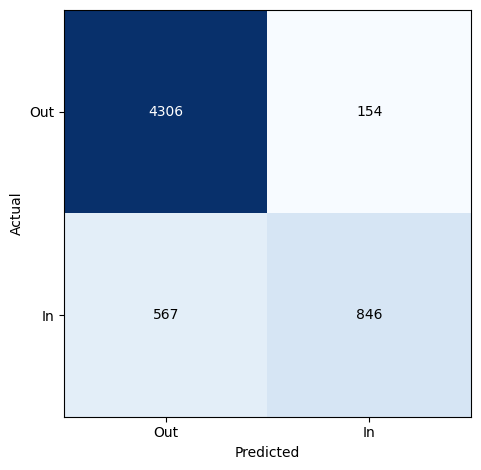

In [5]:
# テストデータで予測
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 分類レポート
print(classification_report(y_test, y_pred, digits=4))

# 混同行列を描画
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Out','In']); ax.set_yticklabels(['Out','In'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
fig.tight_layout()
plt.show()


# ────────────────
# 閾値調整による Recall 向上
# ────────────────

In [12]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# 1. 複勝確率を再利用
# y_proba は上のセルですでに定義済み

# 2. Precision–Recall curve の計算

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# 3. 目標 Recall（例：0.75）を満たす最小の閾値を探す

In [14]:
desired_recall = 0.75
idx = np.where(recall[:-1] >= desired_recall)[0]
if len(idx) > 0:
    opt_idx = idx[0]
    opt_threshold = thresholds[opt_idx]
    print(f"Recall ≥ {desired_recall:.2f} を満たす最小閾値: {opt_threshold:.3f}")
    print(f"このときの Precision: {precision[opt_idx]:.3f}, Recall: {recall[opt_idx]:.3f}")
else:
    print(f"Recall ≥ {desired_recall:.2f} を満たす閾値は見つかりませんでした。")

Recall ≥ 0.75 を満たす最小閾値: 0.000
このときの Precision: 0.241, Recall: 1.000


# 4. 新閾値での予測

In [16]:
y_pred_adj = (y_proba >= opt_threshold).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print("\n=== 新閾値適用後の分類レポート ===")
print(classification_report(y_test, y_pred_adj, digits=4))
print("=== 新閾値適用後の混同行列 ===")
print(confusion_matrix(y_test, y_pred_adj))


=== 新閾値適用後の分類レポート ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4460
           1     0.2406    1.0000    0.3879      1413

    accuracy                         0.2406      5873
   macro avg     0.1203    0.5000    0.1939      5873
weighted avg     0.0579    0.2406    0.0933      5873

=== 新閾値適用後の混同行列 ===
[[   0 4460]
 [   0 1413]]


/home/tsubasa/.pyenv/versions/keiba-ai-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsubasa/.pyenv/versions/keiba-ai-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsubasa/.pyenv/versions/keiba-ai-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# ──────────────────────────────
# ここから F1 スコアを最大化する閾値探索を追加
# ──────────────────────────────

In [17]:
from sklearn.metrics import f1_score

# thresholds 配列に対して、それぞれの閾値での F1 を計算

In [18]:
f1_scores = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]

# 最良 F1 を示す閾値を抽出

In [19]:
best_idx    = int(np.argmax(f1_scores))
best_threshold = thresholds[best_idx]
best_f1     = f1_scores[best_idx]
print(f"\n★ Best F1={best_f1:.3f} を実現する閾値: {best_threshold:.3f}")


★ Best F1=0.746 を実現する閾値: 0.390


# その閾値で再評価

In [20]:
y_pred_f1 = (y_proba >= best_threshold).astype(int)
print("\n=== F1最大化閾値適用後の分類レポート ===")
print(classification_report(y_test, y_pred_f1, digits=4))
print("=== F1最大化閾値適用後の混同行列 ===")
print(confusion_matrix(y_test, y_pred_f1))


=== F1最大化閾値適用後の分類レポート ===
              precision    recall  f1-score   support

           0     0.9222    0.9137    0.9179      4460
           1     0.7352    0.7565    0.7457      1413

    accuracy                         0.8759      5873
   macro avg     0.8287    0.8351    0.8318      5873
weighted avg     0.8772    0.8759    0.8765      5873

=== F1最大化閾値適用後の混同行列 ===
[[4075  385]
 [ 344 1069]]


# ────────────
# ① モデルと閾値の保存
# ────────────

In [21]:
import joblib
import json
import os

# モデル保存用ディレクトリを作成

In [22]:
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# 1) ランダムフォレストモデルを保存

In [23]:
model_path = os.path.join(model_dir, 'keiba_rf_model.pkl')
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/keiba_rf_model.pkl


# 2) 最適閾値と F1 スコアを JSON で保存

In [24]:
thresh_info = {
    'best_threshold': float(best_threshold),  # F1最大化閾値
    'best_f1_score': float(best_f1)          # そのときの F1
}
thresh_path = os.path.join(model_dir, 'threshold.json')
with open(thresh_path, 'w') as f:
    json.dump(thresh_info, f, indent=2)
print(f"Threshold info saved to {thresh_path}")

Threshold info saved to ../models/threshold.json
